# HW3 Practical: Comparing Generative Paradigms on CIFAR-10


Welcome! This notebook provides the training and evaluation pipeline for the four generative models you will build in `models/`.

- Run the setup cells to install dependencies and load CIFAR-10.
- Complete the TODOs in the Python modules, verify with Gradescope autograder, then return here to train and evaluate models.
- Follow the prompts in each section to log results and save artefacts (sample image grids, metrics, and plots) for inclusion in your PDF report.


In [3]:
# Install lightweight dependencies (safe to re-run)
%pip install --quiet torch-fidelity tqdm


In [4]:
import math
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm

from cifar10 import load_cifar10
from models.gan import DCGAN
from models.vae import ConvVAE
from models.pixelcnn import PixelCNN
from models.ddpm import DenoiseUNet

from torch_fidelity import calculate_metrics

In [5]:
# Global configuration
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

BATCH_SIZE = 128
NUM_WORKERS = 0
IMAGE_SIZE = 32
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
print(f"Project root: {PROJECT_ROOT}")


Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Project root: /content


In [6]:
# Purely for me: save in google cloud drive to let it run overnight:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Experiment presets

The dictionaries below define the baseline ("small") and scaled ("medium") configurations used in the assignment. Baselines train for 30 epochs, and the scaled variants run for 40 epochs so you can contrast added capacity with extra compute. Feel free to explore other values.


In [7]:
EXPERIMENT_CONFIGS = {
    "dcgan": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 128, "epochs": 40, "lr": 2e-4},
    },
    "vae": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 192, "epochs": 40, "lr": 2e-4},
    },
    "pixelcnn": {
        "small": {"hidden_channels": 64, "residual_layers": 5, "epochs": 30, "lr": 3e-4},
        "medium": {"hidden_channels": 96, "residual_layers": 7, "epochs": 40, "lr": 3e-4},
    },
    "ddpm": {
        "small": {"base_channels": 64, "time_channels": 256, "timesteps": 1000, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "time_channels": 256, "timesteps": 750, "epochs": 40, "lr": 2e-4},
    },
}

EXPERIMENT_CONFIGS


{'dcgan': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 128,
   'epochs': 40,
   'lr': 0.0002}},
 'vae': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 192,
   'epochs': 40,
   'lr': 0.0002}},
 'pixelcnn': {'small': {'hidden_channels': 64,
   'residual_layers': 5,
   'epochs': 30,
   'lr': 0.0003},
  'medium': {'hidden_channels': 96,
   'residual_layers': 7,
   'epochs': 40,
   'lr': 0.0003}},
 'ddpm': {'small': {'base_channels': 64,
   'time_channels': 256,
   'timesteps': 1000,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'time_channels': 256,
   'timesteps': 750,
   'epochs': 40,
   'lr': 0.0002}}}

In [8]:
THROUGHPUT_SAMPLES = {
    "dcgan": 1024,
    "vae": 1024,
    "pixelcnn": 1024,  # autoregressive sampling is slow; document your actual sample count if you change this
    "ddpm": 1024,
}

THROUGHPUT_SAMPLES


{'dcgan': 1024, 'vae': 1024, 'pixelcnn': 1024, 'ddpm': 1024}

## Data loading


In [9]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


In [10]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)



def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


## Utility functions


In [11]:
def to_device(batch, device=DEVICE):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}


def images_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor.detach().cpu().clamp(0.0, 1.0)
    tensor = (tensor * 255.0).round().to(torch.uint8)
    return tensor.permute(0, 2, 3, 1).numpy()


def save_image_grid(images: torch.Tensor, path: Path, nrow: int = 8):
    path.parent.mkdir(parents=True, exist_ok=True)
    grid = make_grid(images.detach().cpu(), nrow=nrow, padding=2)
    save_image(grid, str(path))
    return grid


def gather_real_images(loader: DataLoader, max_samples: int = 2048) -> torch.Tensor:
    batches = []
    total = 0
    for batch in loader:
        imgs = batch["images"]
        batches.append(imgs)
        total += imgs.size(0)
        if total >= max_samples:
            break
    return torch.cat(batches, dim=0)[:max_samples]


def compute_kid_score(real_images: torch.Tensor, fake_images: torch.Tensor) -> float:
    real_np = images_to_uint8(real_images)
    fake_np = images_to_uint8(fake_images)

    from torch.utils.data import Dataset

    class _ArrayDataset(Dataset):
        def __init__(self, array: np.ndarray):
            self.array = array

        def __len__(self) -> int:
            return self.array.shape[0]

        def __getitem__(self, idx: int):
            arr = self.array[idx]
            tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
            return tensor

    metrics = calculate_metrics(
        input1=_ArrayDataset(fake_np),
        input2=_ArrayDataset(real_np),
        kid=True,
        fid=False,
        verbose=False,
    )
    kid_key = "kernel_inception_distance_mean"
    if kid_key not in metrics:
        kid_key = "kid_mean"
    kid_value = metrics.get(kid_key)
    if kid_value is None:
        raise KeyError(f"KID metric missing expected keys: {list(metrics.keys())}")
    return float(kid_value)


def measure_sampling_throughput(sample_fn, num_images: int = 1024, device=DEVICE):
    torch.cuda.empty_cache()
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.perf_counter()
    samples = sample_fn(num_images=num_images, device=device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    elapsed = time.perf_counter() - start
    throughput = num_images / elapsed
    return samples, elapsed, throughput


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [12]:
real_subset = gather_real_images(val_loader, max_samples=2048)
real_subset_device = real_subset.to(DEVICE)
print(f"Real subset cached: {real_subset.shape} (device copy: {real_subset_device.shape})")



Real subset cached: torch.Size([2048, 3, 32, 32]) (device copy: torch.Size([2048, 3, 32, 32]))


## Training loops


In [13]:
def _init_history():
    return defaultdict(list)

def train_dcgan(model: DCGAN, dataloader: DataLoader, optimizer_g, optimizer_d, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)

            model.zero_grad(set_to_none=True)
            optimizer_d.zero_grad(set_to_none=True)
            out_d = model({"images": images})
            loss_d = out_d["discriminator_loss"]
            loss_d.backward()
            optimizer_d.step()

            model.zero_grad(set_to_none=True)
            optimizer_g.zero_grad(set_to_none=True)
            out_g = model({"images": images})
            loss_g = out_g["generator_loss"]
            loss_g.backward()
            optimizer_g.step()

            history["d_loss"].append(loss_d.item())
            history["g_loss"].append(loss_g.item())
            progress.set_postfix({"d": loss_d.item(), "g": loss_g.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_vae(model: ConvVAE, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[VAE] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            history["kl"].append(out["kl"].mean().item())
            history["recon"].append(out["reconstruction_loss"].mean().item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_pixelcnn(model: PixelCNN, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[PixelCNN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_ddpm(model: DenoiseUNet, dataloader: DataLoader, optimizer, epochs: int = 1, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DDPM] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history



## Sampling & evaluation helper functions


In [14]:
import torch.nn.functional as F
@torch.no_grad()
def sample_dcgan(model: DCGAN, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        fake = model.sample(z) #sample from the model
        samples.append(fake.detach().cpu())
    return torch.cat(samples, dim=0)


@torch.no_grad()
def sample_vae(model: ConvVAE, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        mean, logvar = model.decode(z) #decode the latent codes using the model
        std = torch.exp(0.5 * logvar)
        draw = torch.normal(mean, std) #sample from the distribution (mean and std)
        samples.append(draw.detach().cpu())
    return torch.cat(samples, dim=0).clamp(0.0, 1.0)


@torch.no_grad()
def sample_pixelcnn(model: PixelCNN, num_samples: int = 16, device=DEVICE, image_size: int = IMAGE_SIZE):
    model.eval()
    model.to(device)
    bins = model.bins
    samples = torch.zeros(num_samples, model.image_channels, image_size, image_size, device=device)
    for row in range(image_size):
        for col in range(image_size):
            logits = model.net(samples) #get the logits from the model & use current state of samples
            logits = logits.view(num_samples, model.image_channels, bins, image_size, image_size)
            #Softmax the logits to get the probability of each bin
            #Only care about current pixel (row, col)
            probs = F.softmax(logits[:, :, :, row, col], dim=2)
            cat = torch.distributions.Categorical(probs=probs)
            pixel = cat.sample()
            pixel = pixel.float() / (bins - 1)
            samples[:, :, row, col] = pixel
    return samples.detach().cpu().clamp(0.0, 1.0)


@torch.no_grad()
def _ddpm_predict_noise(model: DenoiseUNet, xt: torch.Tensor, t: torch.Tensor):
    time_emb = model.time_embedding(t)
    #forward the input through the layers, use same pattern as in forward method of DenoiseUNet
    h0 = model.model["init"](xt)
    skip0, h1 = model.model["down0"](h0, time_emb)
    skip1, h2 = model.model["down1"](h1, time_emb)
    skip2, h3 = model.model["down2"](h2, time_emb)
    h_mid = model.model["mid"](h3, time_emb)
    h = model.model["up2"](h_mid, skip2, time_emb)
    h = model.model["up1"](h, skip1, time_emb)
    h = model.model["up0"](h, skip0, time_emb)
    pred_noise = model.model["out"](h)
    return pred_noise


@torch.no_grad()
def sample_ddpm(model: DenoiseUNet, num_samples: int = 64, device=DEVICE, timesteps: int = None):
    model.eval()
    model.to(device)
    T = timesteps if timesteps is not None else model.timesteps
    betas = model.betas.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = model.alphas_cumprod.to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    xt = torch.randn(num_samples, model.image_channels, IMAGE_SIZE, IMAGE_SIZE, device=device)
    for step in reversed(range(T)):
        t = torch.full((num_samples,), step, device=device, dtype=torch.long)
        pred_noise = _ddpm_predict_noise(model, xt, t) #predict the noise from the model
        beta_t = betas[step]
        sqrt_recip_alpha_t = sqrt_recip_alphas[step]
        sqrt_one_minus_cumprod_t = sqrt_one_minus_cumprod[step]
        model_mean = sqrt_recip_alpha_t * (xt - beta_t / sqrt_one_minus_cumprod_t * pred_noise)
        if step > 0:
            variance = beta_t * (1.0 - alphas_cumprod_prev[step]) / (1.0 - alphas_cumprod[step])
            noise = torch.randn_like(xt)
            #update the image, but mean + sigma * noise
            xt = model_mean + torch.sqrt(variance) * noise
        else:
            xt = model_mean
    return xt.detach().cpu().clamp(-1.0, 1.0)



## Experiment tracking utilities


In [15]:
experiment_log = {}


def record_metrics(model_name: str, variant: str, metrics: dict):
    experiment_log.setdefault(model_name, {})[variant] = metrics


def show_metrics(model_name: str = None):
    if model_name is None:
        for name in experiment_log:
            show_metrics(name)
        return
    print(f"=== {model_name} ===")
    entries = experiment_log.get(model_name, {})
    for variant, metrics in entries.items():
        print(f"  [{variant}]")
        for key, value in metrics.items():
            print(f"    {key}: {value}")
    if not entries:
        print("  (no entries yet)")


## DCGAN (adversarial generation)

Fill in the TODOs inside `models/gan.py` before running this section. The cells below:

1. Instantiate the model and optimizers.
2. Train for the baseline configuration.
3. Generate sample grids, measure KID, and record sampling throughput.
4. Repeat with the medium-scale variant


In [16]:
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["small"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Baseline DCGAN parameters: {count_parameters(dcgan):,}")


Baseline DCGAN parameters: 1,846,980


In [17]:
DCGAN_EPOCHS = dcgan_cfg["epochs"]

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"]  # populate this inside your implementation
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")


[DCGAN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [6.58, 4.84, 4.85, 4.87, 4.87, 4.85, 4.77, 4.78, 4.78, 4.78, 4.77, 4.84, 4.76, 4.81, 4.77, 4.88, 4.9, 4.79, 4.86, 4.83, 4.78, 4.83, 4.77, 4.82, 4.97, 4.81, 4.86, 4.78, 4.82, 4.8]


In [18]:
# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=36, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_baseline.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "baseline",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 219MB/s]


KID (x10^3): 0.060
Sampling time for 1024 images: 0.03 s (throughput 38521.3 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DCGAN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [19]:
dcgan_medium_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]
dcgan_medium = DCGAN(
    image_channels=3,
    latent_dim=dcgan_medium_cfg["latent_dim"],
    base_channels=dcgan_medium_cfg["base_channels"],
)

optim_g_medium = torch.optim.Adam(dcgan_medium.generator.parameters(), lr=dcgan_medium_cfg["lr"], betas=(0.5, 0.999))
optim_d_medium = torch.optim.Adam(dcgan_medium.discriminator.parameters(), lr=dcgan_medium_cfg["lr"], betas=(0.5, 0.999))
print(f"Medium DCGAN parameters: {count_parameters(dcgan_medium):,}")

dcgan_medium_epochs = dcgan_medium_cfg["epochs"]
# 30
dcgan_medium_history = train_dcgan(
    dcgan_medium,
    train_loader,
    optimizer_g=optim_g_medium,
    optimizer_d=optim_d_medium,
    epochs=30,
)
dcgan_medium_train_time_30 = sum(dcgan_medium_history["epoch_time"])

# Eval after 30 epochs
samples_30_medium, _, _ = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan_medium, num_samples=num_images , device=device) + 1.0) / 2.0,
    num_images=THROUGHPUT_SAMPLES["dcgan"],
    device=DEVICE,
)

# kid
kid_medium_30 = compute_kid_score(real_subset_device[:samples_30_medium.size(0)].cpu(), samples_30_medium.cpu())
record_metrics(
    "DCGAN",
    "scaled-30ep",
    {
        "epochs": 30,
        "params": count_parameters(dcgan_medium),
        "kid": kid_medium_30,
        "train_time_total_s": dcgan_medium_train_time_30,
        "train_time_per_epoch_s": dcgan_medium_train_time_30,
    },
)

# train the remaining epochs
remaining_epochs = dcgan_medium_epochs - 30
if remaining_epochs > 0:
    dcgan_medium_history_extra = train_dcgan(
        dcgan_medium,
        train_loader,
        optimizer_g=optim_g_medium,
        optimizer_d=optim_d_medium,
        epochs=remaining_epochs)
    # have to merge
    for key, values in dcgan_medium_history_extra.items():
        dcgan_medium_history[key].extend(values)

dcgan_medium_train_time_total = sum(dcgan_medium_history["epoch_time"])

# Final evaluation (40)
samples_40_medium, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan_medium, num_samples=num_images , device=device) + 1.0) / 2.0,
    num_images=THROUGHPUT_SAMPLES["dcgan"],
    device=DEVICE,
)

kid_medium_40 = compute_kid_score(real_subset_device[:samples_40_medium.size(0)].cpu(), samples_40_medium.cpu())

save_image_grid(samples_40_medium[:64], ARTIFACT_DIR / "dcgan_samples_medium_40epochs.png", nrow=8)

record_metrics(
    "DCGAN",
    "scaled-40ep",
    {
        "epochs": dcgan_medium_epochs,
        "params": count_parameters(dcgan_medium),
        "kid": kid_medium_40,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_medium_train_time_total,
    },
)
print(f"DCGAN Medium (40ep) KID: {kid_medium_40:.3f}")

Medium DCGAN parameters: 3,753,508


[DCGAN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DCGAN] Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

DCGAN Medium (40ep) KID: 0.075


## Convolutional VAE (latent variable model)

Make sure the loss components in `models/vae.py` are implemented before training.


In [20]:
vae_cfg = EXPERIMENT_CONFIGS["vae"]["small"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Baseline VAE parameters: {count_parameters(vae):,}")


Baseline VAE parameters: 3,518,214


In [21]:
VAE_EPOCHS = vae_cfg["epochs"]

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside your implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")


[VAE] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished VAE training: 11730 steps
VAE training time per epoch (s): [3.4, 3.05, 3.05, 3.06, 3.23, 3.17, 3.09, 3.07, 3.14, 3.12, 3.06, 3.05, 3.11, 3.07, 3.06, 3.08, 3.14, 3.07, 3.04, 3.01, 3.1, 3.06, 3.02, 3.04, 3.24, 3.14, 3.08, 3.05, 3.14, 3.07]


In [22]:
def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


# TODO: once `sample_vae' are implemented, run the evaluation below.

vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=36, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_baseline.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "baseline",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Validation ELBO: -3505.6092 (recon -3743.2526, KL 237.6435)
KID (x10^3): 0.295
Sampling time for 1024 images: 0.02 s (throughput 44770.3 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration and log metrics after 30 and 40 epochs (e.g. `record_metrics("VAE", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [23]:
vae_medium_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]
vae_medium = ConvVAE(
    image_channels=3,
    latent_dim=vae_medium_cfg["latent_dim"],
    base_channels=vae_medium_cfg["base_channels"],
)

optim_vae_medium = torch.optim.Adam(vae_medium.parameters(), lr=vae_medium_cfg["lr"])
print(f"Medium VAE parameters: {count_parameters(vae_medium):,}")

vae_medium_epochs = vae_medium_cfg["epochs"]

# 30 epochs
vae_medium_history = train_vae(
    vae_medium,
    train_loader,
    optimizer=optim_vae_medium,
    epochs=30,
)

vae_medium_time_30 = sum(vae_medium_history["epoch_time"])

# Evaluation
vae_medium_elbo_30 = evaluate_vae_elbo(vae_medium, val_loader)
vae_samples_30_medium, _, _ = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae_medium, num_samples=num_images , device=device),
    num_images=THROUGHPUT_SAMPLES["vae"],
    device=DEVICE,
)

kid_medium_30 = compute_kid_score(real_subset_device[:vae_samples_30_medium.size(0)].cpu(), vae_samples_30_medium.cpu())

record_metrics( "VAE", "scaled-30ep", {
    "epochs": 30,
    "params": count_parameters(vae_medium),
    "kid": kid_medium_30,
    "nll": vae_medium_elbo_30["loss"],
    "train_time_total_s": vae_medium_time_30,
})
print(f"Medium VAE after 30 epochs - ELBO: {vae_medium_elbo_30['loss']:.4f}, KID (x10^3): {kid_medium_30:.3f}")

# train remaining epochs
remaining_epochs = vae_medium_epochs - 30
if remaining_epochs > 0:
    vae_medium_history_extra = train_vae(
        vae_medium,
        train_loader,
        optimizer=optim_vae_medium,
        epochs=remaining_epochs)
    # have to merge
    for key, values in vae_medium_history_extra.items():
        vae_medium_history[key].extend(values)

vae_medium_time_total = sum(vae_medium_history["epoch_time"])

# Final evaluation (40)
vae_medium_elbo_40 = evaluate_vae_elbo(vae_medium, val_loader)
vae_samples_40_medium, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae_medium, num_samples=num_images , device=device),
    num_images=THROUGHPUT_SAMPLES["vae"],
    device=DEVICE,
)
kid_medium_40 = compute_kid_score(real_subset_device[:vae_samples_40_medium.size(0)].cpu(), vae_samples_40_medium.cpu())

save_image_grid(vae_samples_40_medium[:64], ARTIFACT_DIR / "vae_samples_medium_40epochs.png", nrow=8)

record_metrics(
    "VAE",
    "scaled-40ep",
    {
        "epochs": vae_medium_epochs,
        "params": count_parameters(vae_medium),
        "kid": kid_medium_40,
        "nll": vae_medium_elbo_40["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_medium_time_total,
    },
)

print(f"Medium VAE after 40 epochs - NLL ELBO: {vae_medium_elbo_40['loss']:.4f}, KID (x10^3): {kid_medium_40:.3f}")

Medium VAE parameters: 7,906,950


[VAE] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Medium VAE after 30 epochs - ELBO: -3672.7710, KID (x10^3): 0.294


[VAE] Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

[VAE] Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Medium VAE after 40 epochs - NLL ELBO: -4149.6213, KID (x10^3): 0.290


## PixelCNN (autoregressive generation)

Ensure the masking logic and loss in `models/pixelcnn.py` are implemented.


In [24]:
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["small"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Baseline PixelCNN parameters: {count_parameters(pixelcnn):,}")


Baseline PixelCNN parameters: 268,992


In [25]:
PIXELCNN_EPOCHS = pixelcnn_cfg["epochs"]

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside your implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")


[PixelCNN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [7.56, 7.41, 7.4, 7.41, 7.4, 7.41, 7.43, 7.4, 7.39, 7.41, 7.39, 7.41, 7.39, 7.4, 7.42, 7.41, 7.4, 7.39, 7.42, 7.4, 7.4, 7.4, 7.39, 7.4, 7.41, 7.4, 7.4, 7.4, 7.39, 7.41]


In [26]:
def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=36, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_baseline.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "baseline",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


Validation NLL: 3.7260
KID (x10^3): 0.229
Sampling time for 1024 images: 34.47 s (throughput 29.70 img/s)


> **Scaling experiment:** > **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("PixelCNN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [27]:
pixel_cnn_medium_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]
pixel_cnn_medium = PixelCNN(image_channels=3,
                            hidden_channels=pixel_cnn_medium_cfg["hidden_channels"],
                            residual_layers=pixel_cnn_medium_cfg["residual_layers"],
                            bins=256,
                            )
optim_pixel_cnn_medium = torch.optim.Adam(pixel_cnn_medium.parameters(), lr=pixel_cnn_medium_cfg["lr"])
print(f"Medium PixelCNN parameters: {count_parameters(pixel_cnn_medium):,}")

# 30 epochs
pixel_cnn_medium_history = train_pixelcnn(pixel_cnn_medium, train_loader, optimizer=optim_pixel_cnn_medium, epochs= 30)
pixel_cnn_medium_time_30 = sum(pixel_cnn_medium_history["epoch_time"])

# Eval 30
pixel_cnn_medium_nll_30 = evaluate_pixelcnn_nll(pixel_cnn_medium, val_loader)
pixel_cnn_samples_30_medium, _, _ = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixel_cnn_medium, num_samples=num_images, device=device),
    num_images=THROUGHPUT_SAMPLES["pixelcnn"],
    device=DEVICE,
)

kid_medium_30 = compute_kid_score(real_subset_device[:pixel_cnn_samples_30_medium.size(0)].cpu(), pixel_cnn_samples_30_medium.cpu())

record_metrics(
    "PixelCNN",
    "scaled-30ep",
    {
        "epochs": 30,
        "params": count_parameters(pixel_cnn_medium),
        "kid": kid_medium_30,
        "nll": pixel_cnn_medium_nll_30,
        "train_time_total_s": pixel_cnn_medium_time_30,
        "train_time_per_epoch_s": pixel_cnn_medium_time_30 / 30,
    })

# Remaining epochs
remaining_epochs = pixel_cnn_medium_cfg["epochs"] - 30
if remaining_epochs > 0:
  pixel_cnn_medium_history_extra = train_pixelcnn(pixel_cnn_medium, train_loader, optimizer=optim_pixel_cnn_medium, epochs=remaining_epochs)
  for key, values in pixel_cnn_medium_history_extra.items():
    pixel_cnn_medium_history[key].extend(values)

pixel_cnn_medium_time_total = sum(pixel_cnn_medium_history["epoch_time"])

# Final evaluation (40 epochs)
pixel_cnn_medium_nll_40 = evaluate_pixelcnn_nll(pixel_cnn_medium, val_loader)
pixel_cnn_samples_40_medium, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixel_cnn_medium, num_samples=num_images, device=device),
    num_images=THROUGHPUT_SAMPLES["pixelcnn"],
    device=DEVICE,
)

kid_medium_40 = compute_kid_score(real_subset_device[:pixel_cnn_samples_40_medium.size(0)].cpu(), pixel_cnn_samples_40_medium.cpu())
save_image_grid(pixel_cnn_samples_40_medium[:64], ARTIFACT_DIR / "pixelcnn_samples_medium_40epochs.png", nrow=8)

record_metrics(
    "PixelCNN", "scaled-40ep",
    {
        "epochs": pixel_cnn_medium_cfg["epochs"],
        "params": count_parameters(pixel_cnn_medium),
        "kid": kid_medium_40,
        "nll": pixel_cnn_medium_nll_40,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixel_cnn_medium_time_total,
    },
)

print(f"PixelCNN Medium after 40 epochs - NLL ELBO: {pixel_cnn_medium_nll_40:.4f}, KID: {kid_medium_40:.3f}")

Medium PixelCNN parameters: 744,480


[PixelCNN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

[PixelCNN] Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

PixelCNN Medium after 40 epochs - NLL ELBO: 3.5850, KID: 0.275


## DDPM (diffusion model)

Verify the diffusion loss path in `models/ddpm.py` before running.

In [28]:
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["small"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Baseline DDPM parameters: {count_parameters(ddpm):,}")


Baseline DDPM parameters: 6,993,987


In [29]:
DDPM_EPOCHS = ddpm_cfg["epochs"]

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"]  # populate this inside your implementation
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")


[DDPM] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [13.21, 12.84, 12.86, 12.86, 12.84, 12.83, 12.84, 12.83, 12.81, 12.83, 13.0, 12.92, 12.95, 12.9, 12.9, 12.95, 12.94, 12.97, 12.91, 12.92, 12.88, 12.85, 12.87, 12.87, 12.86, 12.86, 12.92, 12.91, 12.86, 12.88]


In [30]:
# TODO: once `sample_ddpm` is implemented, run the evaluation block below.
ddpm_samples = sample_ddpm(ddpm, num_samples=36, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_baseline.png", nrow=6)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "baseline",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


KID (x10^3): 0.056
Sampling time for 1024 images: 62.03 s (throughput 16.51 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DDPM", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [31]:
ddpm_medium_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]
ddpm_medium = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_medium_cfg["base_channels"],
    time_channels=ddpm_medium_cfg["time_channels"],
    timesteps=ddpm_medium_cfg["timesteps"],
)
optim_ddpm_medium = torch.optim.Adam(ddpm_medium.parameters(), lr=ddpm_medium_cfg["lr"])
print(f"Medium DDPM parameters: {count_parameters(ddpm_medium):,}")

# 30 epochs
ddpm_medium_history = train_ddpm(ddpm_medium, train_loader, optimizer=optim_ddpm_medium, epochs=30)
ddpm_medium_time_30 = sum(ddpm_medium_history["epoch_time"])

# Eval
ddpm_samples_30_medium, _, _ = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm_medium, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=THROUGHPUT_SAMPLES["ddpm"],
    device=DEVICE,
)

kid_medium_30 = compute_kid_score(real_subset_device[:ddpm_samples_30_medium.size(0)].cpu(), ddpm_samples_30_medium.cpu())

record_metrics(
    "DDPM",
    "scaled-30ep",
    {
        "epochs": 30,
        "params": count_parameters(ddpm_medium),
        "kid": kid_medium_30,
        "train_time_total_s": ddpm_medium_time_30,
        "train_time_per_epoch_s": ddpm_medium_time_30 / 30,
    })

# Remaining epochs
remaining_epochs = ddpm_medium_cfg["epochs"] - 30
if remaining_epochs > 0:
  ddpm_medium_history_extra = train_ddpm(ddpm_medium, train_loader, optimizer=optim_ddpm_medium, epochs=remaining_epochs)
  for key, values in ddpm_medium_history_extra.items():
    ddpm_medium_history[key].extend(values)

ddpm_medium_time_total = sum(ddpm_medium_history["epoch_time"])

# Final eval
ddpm_samples_40_medium, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm_medium, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=THROUGHPUT_SAMPLES["ddpm"],
    device=DEVICE,
)

kid_medium_40 = compute_kid_score(real_subset_device[:ddpm_samples_40_medium.size(0)].cpu(), ddpm_samples_40_medium.cpu())
save_image_grid(ddpm_samples_40_medium[:64], ARTIFACT_DIR / "ddpm_samples_medium_40epochs.png", nrow=8)

record_metrics(
    "DDPM",
    "scaled-40ep",
    {
        "epochs": ddpm_medium_cfg["epochs"],
        "params": count_parameters(ddpm_medium),
        "kid": kid_medium_40,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_medium_time_total,
    })
print(f"DDPM Medium after 40 epochs - KID (x10^3): {kid_medium_40:.3f}")



Medium DDPM parameters: 14,747,107


[DDPM] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 11/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 12/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 13/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 14/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 15/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 16/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 17/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 18/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 19/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 20/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 21/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 22/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 23/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 24/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 25/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 26/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 27/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 28/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 29/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 30/30:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

[DDPM] Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

DDPM Medium after 40 epochs - KID (x10^3): 0.058


## Summary & export

After running the experiments above (small and medium variants), use the helper below to view logged metrics and export them to disk.

In [32]:
import json
import pandas as pd

show_metrics()

rows = []
for model_name, variants in experiment_log.items():
    for variant, metrics in variants.items():
        row = {"model": model_name, "variant": variant}
        row.update(metrics)
        rows.append(row)
if rows:
    df_metrics = pd.DataFrame(rows)
    display(df_metrics.set_index(["model", "variant"]))

summary_path = ARTIFACT_DIR / "metrics_summary.json"
with summary_path.open("w") as fp:
    json.dump(experiment_log, fp, indent=2)
print(f"Saved metrics summary to {summary_path}")


=== DCGAN ===
  [baseline]
    epochs: 30
    params: 1846980
    kid: 0.06016730070114136
    sampling_time_s: 0.02658272400003625
    throughput_img_per_s: 38521.25914554895
    train_time_total_s: 146.41470535800045
    train_time_per_epoch_s: 4.880490178600015
  [scaled-30ep]
    epochs: 30
    params: 3753508
    kid: 0.04797431707382202
    train_time_total_s: 148.2712345299983
    train_time_per_epoch_s: 148.2712345299983
  [scaled-40ep]
    epochs: 40
    params: 3753508
    kid: 0.07513741731643676
    sampling_time_s: 0.01786479300017163
    throughput_img_per_s: 57319.44389113058
    train_time_total_s: 194.81404257299937
=== VAE ===
  [baseline]
    epochs: 30
    params: 3518214
    kid: 0.29533283233642577
    nll: -3505.60917734375
    sampling_time_s: 0.022872287000154756
    throughput_img_per_s: 44770.33713301479
    train_time_total_s: 93.01316314199858
    train_time_per_epoch_s: 3.1004387713999524
  [scaled-30ep]
    epochs: 30
    params: 7906950
    kid: 0.294103

epochs    params       kid  sampling_time_s  \
model    variant                                                    
DCGAN    baseline         30   1846980  0.060167         0.026583   
         scaled-30ep      30   3753508  0.047974              NaN   
         scaled-40ep      40   3753508  0.075137         0.017865   
VAE      baseline         30   3518214  0.295333         0.022872   
         scaled-30ep      30   7906950  0.294104              NaN   
         scaled-40ep      40   7906950  0.290131         0.021028   
PixelCNN baseline         30    268992  0.229177        34.473131   
         scaled-30ep      30    744480  0.237100              NaN   
         scaled-40ep      40    744480  0.275135        58.358905   
DDPM     baseline         30   6993987  0.056242        62.031196   
         scaled-30ep      30  14747107  0.071513              NaN   
         scaled-40ep      40  14747107  0.057729        78.113403   

                      throughput_img_per_s  train_time_total_s  \
model    variant                                                 
DCGAN    baseline             38521.259146          146.414705   
         scaled-30ep                   NaN          148.271235   
         scaled-40ep          57319.443891          194.814043   
VAE      baseline             44770.337133           93.013163   
         scaled-30ep                   NaN           93.634426   
         scaled-40ep          48697.795274          124.103891   
PixelCNN baseline                29.704294          222.243973   
         scaled-30ep                   NaN          329.274760   
         scaled-40ep             17.546594          439.442888   
DDPM     baseline                16.507823          386.888059   
         scaled-30ep                   NaN          565.986040   
         scaled-40ep             13.109146          755.024964   

                      train_time_per_epoch_s          nll  
model    variant                                           
DCGAN    baseline                   4.880490          NaN  
         scaled-30ep              148.271235          NaN  
         scaled-40ep                     NaN          NaN  
VAE      baseline                   3.100439 -3505.609177  
         scaled-30ep                     NaN -3672.770954  
         scaled-40ep                     NaN -4149.621294  
PixelCNN baseline                   7.408132     3.725953  
         scaled-30ep               10.975825     3.611529  
         scaled-40ep                     NaN     3.585037  
DDPM     baseline                  12.896269          NaN  
         scaled-30ep               18.866201          NaN  
         scaled-40ep                     NaN          NaN

Saved metrics summary to /content/artifacts/metrics_summary.json


## Aggregate plots

Use this section to generate the plots and figures requested in the assignment.


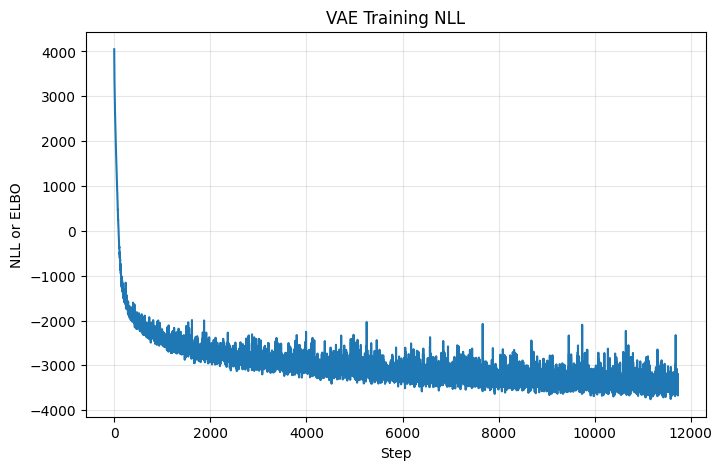

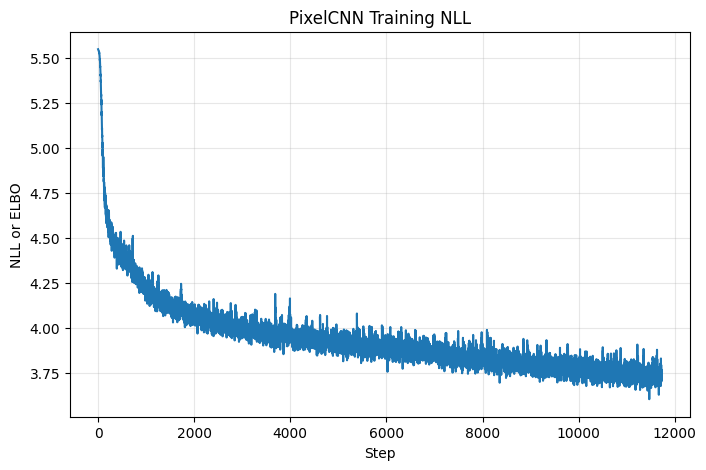

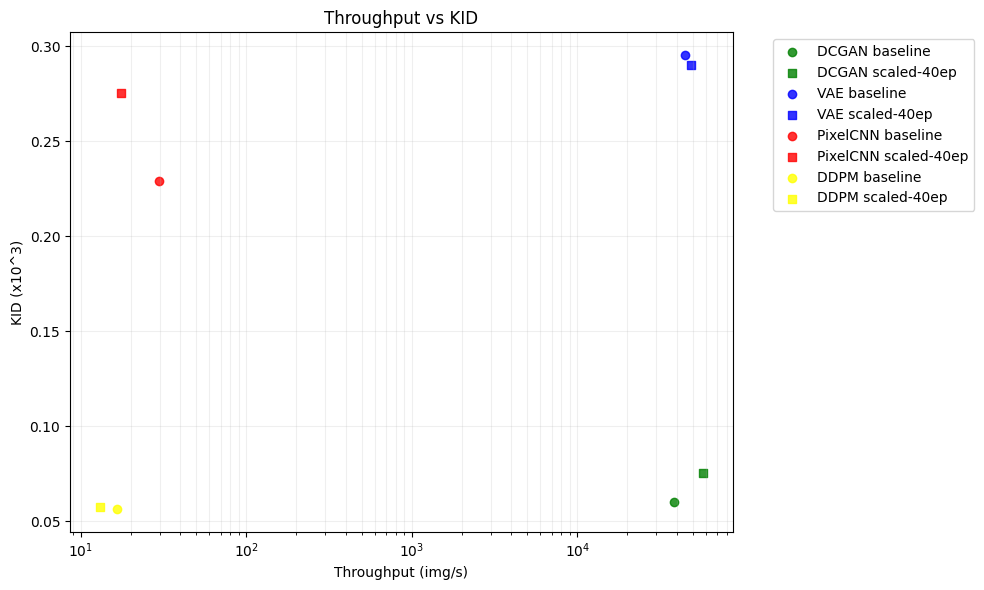

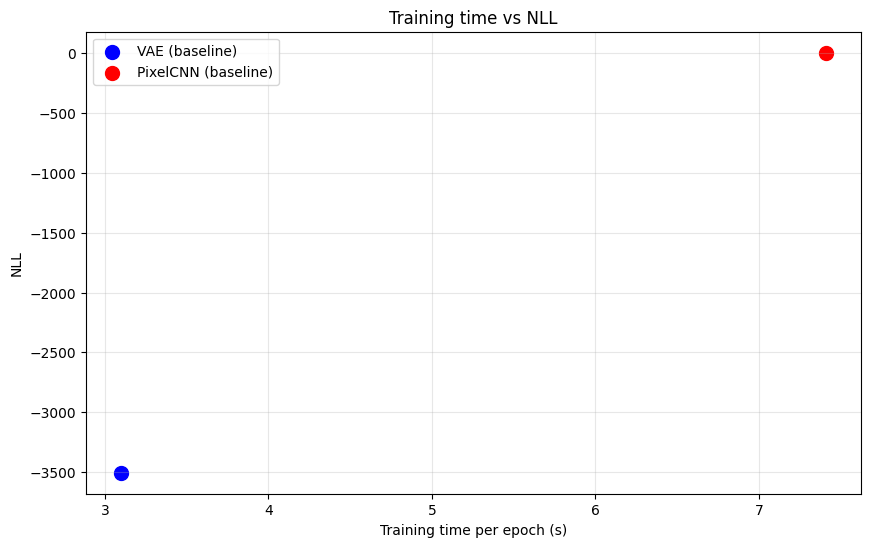


 ********PARAM SCALING********
Model      | Variant         | Params       | KID       
DCGAN      | baseline        | 1846980      | 0.060
DCGAN      | scaled-30ep     | 3753508      | 0.048
DCGAN      | scaled-40ep     | 3753508      | 0.075
VAE        | baseline        | 3518214      | 0.295
VAE        | scaled-30ep     | 7906950      | 0.294
VAE        | scaled-40ep     | 7906950      | 0.290
PixelCNN   | baseline        | 268992       | 0.229
PixelCNN   | scaled-30ep     | 744480       | 0.237
PixelCNN   | scaled-40ep     | 744480       | 0.275
DDPM       | baseline        | 6993987      | 0.056
DDPM       | scaled-30ep     | 14747107     | 0.072
DDPM       | scaled-40ep     | 14747107     | 0.058


In [33]:
import matplotlib.pyplot as plt
# thank you to https://realpython.com/python-matplotlib-guide/

# plot 1: training NLL
def plot_nll(history, title, filename, key="loss"):
  if key in history and len(history[key]) > 0:
    plt.figure(figsize=(8, 5))
    plt.plot(history[key], label="Training")
    plt.xlabel("Step")
    plt.ylabel("NLL or ELBO")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.savefig(ARTIFACT_DIR / filename)
    plt.show()

plot_nll(vae_history, "VAE Training NLL", "vae_nll.png")
plot_nll(pixelcnn_history, "PixelCNN Training NLL", "pixelcnn_nll.png")

# plot 2: throughput vs kid
plt.figure(figsize=(10, 6)) #bit bigger based on early struff
colors = {"dcgan": "green", "vae": "blue", "pixelcnn": "red", "ddpm": "yellow"}
markers = {"baseline": "o", "scaled-40ep": "s"}

for model_name, variants in experiment_log.items():
  color = colors.get(model_name.lower(), "black")
  for variant, metrics in variants.items():
    if "scaled-30ep" in variant: continue
    kid = metrics.get("kid")
    throughput = metrics.get("throughput_img_per_s")
    if kid is not None and throughput is not None:
      marker = markers.get(variant, "x")
      plt.scatter(throughput, kid, c=color, marker=marker, label=f"{model_name} {variant}", alpha=0.8)

plt.xscale("log")
plt.xlabel("Throughput (img/s)")
plt.ylabel("KID (x10^3)")
plt.title("Throughput vs KID")
plt.grid(True, which="both", alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / "throughput_vs_kid.png")
plt.show()

# plot 3: compute vs nll
plt.figure(figsize=(10, 6))
for model_name in ["VAE", "PixelCNN"]:
  variants = experiment_log.get(model_name, {})
  color = colors.get(model_name.lower(), "black")
  for variant, metrics in variants.items():
    if "scaled-30ep" in variant: continue
    nll = metrics.get("nll")
    t_epoch = metrics.get("train_time_per_epoch_s")
    if nll is not None and t_epoch is not None:
      plt.scatter(t_epoch, nll, c=color, s=100, label=f"{model_name} ({variant})")

plt.xlabel("Training time per epoch (s)")
plt.ylabel("NLL")
plt.title("Training time vs NLL")
plt.grid(True, alpha=0.3)
plt.legend()
plt.savefig(ARTIFACT_DIR / "compute_vs_nll.png")
plt.show()

# Final table for param scaling
print("\n ********PARAM SCALING********")
# use :< for clean table
print(f"{'Model':<10} | {'Variant':<15} | {'Params':<12} | {'KID':<10}")
for model_name, variants in experiment_log.items():
  for logged_v in sorted(variants.keys()):
    print(f"{model_name:<10} | {logged_v:<15} | {variants[logged_v].get('params', 0):<12} | {variants[logged_v].get('kid',0):.3f}")


In [34]:
# Purely for me: save cell for drive. It would timeout overnight and prevent me saving results
import shutil
import os
from datetime import datetime

drive_f = "content/drive/MyDrive/H3_Results"
os.makedirs(drive_f, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_name = f"artifacts_q1_{timestamp}"
zip_path = f"/content/{zip_name}"

print(f"Zip to {zip_path}.zip")
shutil.make_archive(zip_path, 'zip', str(ARTIFACT_DIR))
destination_path = os.path.join(drive_f, f"{zip_name}.zip")
shutil.copy(f"{zip_path}.zip", destination_path)
print("artifacts saved to drive")

Zip to /content/artifacts_q1_20251208_000724.zip
artifacts saved to drive


In [36]:
#Purely for me: save to pc just in case.
from google.colab import files
files.download(f"{zip_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>